# Projet du cours "Kernel methods" du master MVA
Le projet de ce cours consiste en la classification d'images. Dans ce notebook, on implémente de manière la plus détaillée et la plus claire possible l'ensemble des classes et fonctions des algorithmes que nous utilisons.    

Ce projet se fera en 3 étapes :
- Preprocessing des données
- Feature extraction
- Prediction par SVM

Il est indiqué dans l'énoncé que l'étape de preprocessing a déjà été réalisée. Nous allons donc directement procéder à l'extraction de nos features (par ACP et HOG) et à la prédiction de la nature de nos images (par SVM).

## Chargement des modules

In [1]:
%pylab inline
import pandas
import cvxopt
import time
import numpy as np
import numpy.linalg as la
import scipy
from scipy.stats import mode
import matplotlib.pyplot as plt 

Populating the interactive namespace from numpy and matplotlib


# Importation des données

On importe les données du concours

In [2]:
df_train=pandas.read_csv('/Users/badr-eddinecherief-abdellatif/Documents/ENSAE/3A/MVA/Kernel methods/Projet ENS/Bases/Xtr.csv',header=None,sep=',')
df_train=df_train.drop(3072,1)
df_test=pandas.read_csv('/Users/badr-eddinecherief-abdellatif/Documents/ENSAE/3A/MVA/Kernel methods/Projet ENS/Bases/Xte.csv',header=None,sep=',')
df_test=df_test.drop(3072,1)
y_train=pandas.read_csv('/Users/badr-eddinecherief-abdellatif/Documents/ENSAE/3A/MVA/Kernel methods/Projet ENS/Bases/Ytr.csv',sep=';')
y_train=pandas.DataFrame(y_train['Prediction'])

# Une première visualisation
Voyons une première image

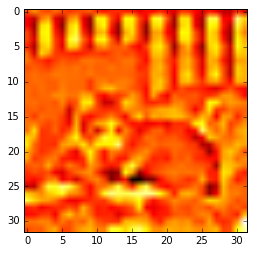

In [4]:
img = df_train.iloc[9,0:1024].reshape(32,32)
plt.imshow(img, cmap=cm.hot) 

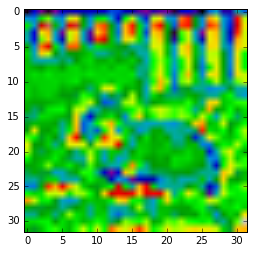

In [5]:
img = df_train.iloc[9,1024:2048].reshape(32,32)
plt.imshow(img, cmap=cm.nipy_spectral) 

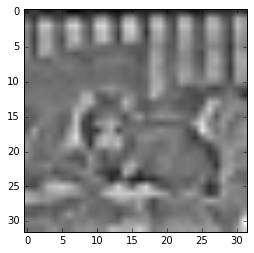

In [6]:
img = df_train.iloc[9,2048:3072].reshape(32,32)
plt.imshow(img, cmap=cm.gray) 

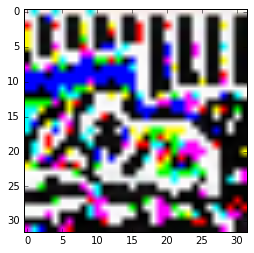

In [7]:
img = df_train.iloc[9,:].reshape(3,32,32).transpose(1,2,0)
plt.imshow(img, cmap=cm.gray) 

# Répartition des labels
Nous travaillons sur un échantillon d'apprentissage dans le but de classifier des images. Vérifions que nous avons bien équirépartition des images dans l'échantillon d'apprentissage afin de pouvoir mener à bien notre modélisation

In [8]:
y_train["Prediction"].value_counts()

7    500
3    500
6    500
2    500
9    500
5    500
1    500
8    500
4    500
0    500
Name: Prediction, dtype: int64

# Implémentation des méthodes

Dans cette partie, nous implémenterons les différentes méthodes que nous testerons par la suite. Il s'agit des méthodes suivantes:
- SVM
- ACP
- HOG


## Support Vector Machine

In [47]:
class SVMTrain(object):
    def __init__(self, kernel, C):
        self._kernel = kernel
        self._C = C

    def train(self, X, y):
        # Donne une prédiction des images sur un training set à partir d'un noyau, d'un C, 
        # et d'un training set (X,y)
        alpha = self._compute_alpha(X, y)
        return self._construct_predictor(X, y, alpha)

    def _gram_matrix(self, X):
        # Retourne la matrice de Gram associée à un kernel
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i,x_i in enumerate(asmatrix(X,dtype=ndarray)):
            for j,x_j in enumerate(asmatrix(X,dtype=ndarray)):
                K[i,j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, alpha):
        # Donne une prédiction des images sur un training set en construisant un biais 
        # et le supportà partir d'un noyau, d'un C, d'un vecteur alpha représentant le 
        # vecteur de Lagrange solution du dual SVM, et d'un training set (X,y) 
        #(ça nous évite de résoudre le système pour trouver le vecteur solution du dual)
        
        support_vector_indices = abs(alpha) > 0
        support_alpha = alpha[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]
        print("Nombre de vecteurs supports :",len(support_vectors))

        # cf. slides 136/140/141 + HW2 pour les formules
        # bias = y_k - \sum alpha_k  K(x_k, x_i)
        bias = np.mean(
            [y_i - SVMPred(
                kernel=self._kernel,
                bias=0,
                alpha=support_alpha,
                support_vectors=support_vectors).predict(x_i)
             for (y_i, x_i) in zip(support_vector_labels, support_vectors)])
        print("Biais :",bias)

        return SVMPred(
            kernel=self._kernel,
            bias=bias,
            alpha=support_alpha,
            support_vectors=support_vectors)

    def _compute_alpha(self, X, y):
        n_samples, n_features = X.shape

        # Résout le Quadratic Program suivant (retourne les coefficients alphas qui résolvent le QP) (cf. slide 136)
        # min { 1/2 x^T P x + q^T x }
        # s.t.
        #      Gx <= h
        #      Ax = b
        # with P = Gram matrix, q = - y, G = [diag(y),-diag(y)]', h = [C, ..., C, 0, ..., 0]', A = [1, ..., 1], b = [0 
        # On cherche ici à résoudre le problème qu'on a évité juste avant

        P = cvxopt.matrix(self._gram_matrix(X))
        q = cvxopt.matrix(array(-y))

        # - alpha_i * y_i <= 0
        G_geq = cvxopt.matrix(np.diag([array(-y)[i,0] for i in range(len(y))]))
        h_geq = cvxopt.matrix(np.zeros(n_samples))

        # alpha_i * y_i <= C
        G_leq = cvxopt.matrix(np.diag([array(y)[i,0] for i in range(len(y))]))
        h_leq = cvxopt.matrix(np.ones(n_samples) * self._C)

        G = cvxopt.matrix(np.concatenate((G_geq, G_leq)))
        h = cvxopt.matrix(np.concatenate((np.array(h_geq),np.array(h_leq))))

        A = cvxopt.matrix(np.ones(n_samples), (1, n_samples))
        b = cvxopt.matrix(0.0)

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        return np.ravel(solution['x'])

In [46]:
class SVMPred(object):
    def __init__(self,
                 kernel,
                 bias,
                 alpha,
                 support_vectors):
        self._kernel = kernel
        self._bias = bias
        self._alpha = alpha
        self._support_vectors = support_vectors

    def predict(self, x):
        # Computes the SVM prediction of a new point x given a bias, a kernel, some support vectors and alphas
        result = self._bias
        for alpha_i, x_i in zip(transpose(self._alpha),transpose(self._support_vectors)):
            result += alpha_i * self._kernel(x_i, x)
        return np.sign(result),result

In [28]:
class Kernel(object):
    
    # On implémente quelques kernels : linear, polynomial, RBF
    
    @staticmethod
    def linear():
        return lambda x,y: np.inner(x, y)

    @staticmethod
    def RBF(sigma):
        return lambda x,y: np.exp(- np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2)))

    @staticmethod
    def polynomial(degree, constant):
        return lambda x,y: (constant + np.inner(x, y)) ** degree

## Adaptation du SVM au cas multi-classe
On va tout d'abord implémenter la méthode One Vs One, i.e. considérer 10x9/2=45 problèmes de classifications binaires en traitant des paires d'instances, puis implémenter la méthode One Vs Rest, i.e. entraîner un classifieur par classe.

### One Vs One

In [13]:
def SVMOvO(data_train,data_test,is_train,kernel,C):
    # Renvoie pour un training set et un test set, une sous-partie considérée de ce train set
    # qui servira pour l'évaluation de nos prédictions sur ce sous-échantillon, un kernel, et 
    # un C, une prédiction de nos classes évaluée sur la sous-partie
    SVM=SVMTrain(kernel,C)
    result=(10*ones(len(data_test))).reshape(len(data_test),1)
    for i in [0,1,2,3,4,5,6,7,8]:
        for j in range(i+1,10):
            print("Classe :",i,j)
            df_train_ij=data_train[asmatrix(is_train,dtype=ndarray)==(i,j)].copy()
            is_train_ij=is_train[asmatrix(is_train,dtype=ndarray)==(i,j)].copy()
            is_train_ij[is_train==i]=1
            is_train_ij[is_train==j]=-1
            s1=time.clock()
            SVMPrediction=SVM.train(df_train_ij,asfarray(is_train_ij,dtype=float))
            s2=time.clock()
            print("Temps pour l'entrainement :",s2-s1)
            s3=time.clock()
            values=SVMPrediction.predict(data_test.values)[0]
            s4=time.clock()
            print("Temps pour la prédiction :",s4-s3)
            values[values==1]=i
            values[values==-1]=j
            values=values.reshape(len(data_test),1)
            result=concatenate((result,values),1)
            is_test_predict=mode(result,axis=1)
    return(is_test_predict)    

In [50]:
df_train_ij=df_train_1[asmatrix(y_train_1,dtype=ndarray)==(0,1)].copy()
is_train_ij=y_train_1[asmatrix(y_train_1,dtype=ndarray)==(0,1)].copy()
is_train_ij[y_train_1==0]=1
is_train_ij[y_train_1==1]=-1
s1=time.clock()
SVMPrediction=SVMTrain(Kernel().linear(),4).train(df_train_ij,asfarray(is_train_ij,dtype=float))
s2=time.clock()
print("Temps pour l'entrainement :",s2-s1)
s3=time.clock()
values=(SVMPrediction.predict(df_test_1))[0]
s4=time.clock()
print("Temps pour la prédiction :",s4-s3)
values[values==1]=0
values[values==-1]=1
values.reshape(len(df_test_1),1)
result=concatenate((result,values),0)
is_test_predict=mode(result,axis=1)

     pcost       dcost       gap    pres   dres
 0:  1.4358e+02 -8.5703e+03  2e+04  8e-01  4e-15
 1:  2.4256e+02 -3.0886e+03  3e+03  2e-02  4e-15
 2: -3.2842e+01 -5.8123e+02  6e+02  3e-03  3e-15
 3: -1.0385e+02 -1.6890e+02  7e+01  1e-04  2e-15
 4: -1.1208e+02 -1.2277e+02  1e+01  1e-05  2e-15
 5: -1.1380e+02 -1.1491e+02  1e+00  9e-07  2e-15
 6: -1.1406e+02 -1.1412e+02  5e-02  3e-08  2e-15
 7: -1.1408e+02 -1.1408e+02  2e-03  6e-10  2e-15
 8: -1.1408e+02 -1.1408e+02  8e-05  8e-12  2e-15
Optimal solution found.
Nombre de vecteurs supports : 614
Biais : -1269181.14356
Temps pour l'entrainement : 149.82910300000003
Temps pour la prédiction : 48.03429499999993


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [51]:
values

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [55]:
(10*ones(len(df_test_1)))

array([ 10.,  10.,  10., ...,  10.,  10.,  10.])

In [ ]:
df_train_ij=df_train_1[asmatrix(y_train_1,dtype=ndarray)==(0,2)].copy()
is_train_ij=y_train_1[asmatrix(y_train_1,dtype=ndarray)==(0,2)].copy()
is_train_ij[y_train_1==0]=1
is_train_ij[y_train_1==2]=-1
s1=time.clock()
SVMPrediction=SVMTrain(Kernel().linear(),4).train(df_train_ij,asfarray(is_train_ij,dtype=float))
s2=time.clock()
print("Temps pour l'entrainement :",s2-s1)
s3=time.clock()
values=(SVMPrediction.predict(df_test_1.values))[0]
s4=time.clock()
print("Temps pour la prédiction :",s4-s3)
values[values==1]=0
values[values==-1]=2
result=concatenate((result,values),0)
is_test_predict=mode(result,axis=1)

In [ ]:
SVMTrain.gram_matrix(df_train_1)

In [77]:
print(SVMPrediction.predict(df_test_1).shape)

(2000, 3072)


In [32]:
concatenate((result,values),0)

array([ 14.,  14.,  14., ...,   0.,   1.,   1.])

In [49]:
values

array([ 0.,  0.,  0., ...,  0.,  1.,  1.])

In [51]:
SVMPrediction.predict(df_test_1).shape

(2000, 3072)

In [29]:
(14*ones(len(df_test_1))).shape

(2000,)

In [76]:
[x_i for x_i in (df_test_1.values)][0]

array([ 0.05740889,  0.03170839,  0.00996822, ...,  0.01139763,
       -0.01219329, -0.01994567])

In [23]:
n_samples, n_features = df_train_ij.shape
K = np.zeros((n_samples, n_samples))
for i,x_i in enumerate(asmatrix(df_train_ij,dtype=ndarray)):
    for j,x_j in enumerate(asmatrix(df_train_ij,dtype=ndarray)):
        K[i,j] = Kernel().linear()(x_i, x_j)
K

array([[ 5.54814017, -0.06634964, -0.11150961, ..., -0.11277876,
        -0.29878279,  0.35786101],
       [-0.06634964,  4.9380637 ,  0.30413396, ..., -0.15638475,
        -0.1690609 ,  0.62625357],
       [-0.11150961,  0.30413396,  4.9634047 , ...,  0.12704486,
         0.15243402,  0.27243287],
       ..., 
       [-0.11277876, -0.15638475,  0.12704486, ...,  2.69511243,
         0.0118516 ,  0.14661916],
       [-0.29878279, -0.1690609 ,  0.15243402, ...,  0.0118516 ,
         5.14422166, -0.13409068],
       [ 0.35786101,  0.62625357,  0.27243287, ...,  0.14661916,
        -0.13409068,  5.72541333]])

In [22]:
for i,x_i in enumerate(asmatrix(df_train_ij,dtype=ndarray)):
    for j,x_j in enumerate(asmatrix(df_train_ij,dtype=ndarray)):
        print((i,j),Kernel().linear()(x_i, x_j))

(0, 0) [[5.548140172119326]]
(0, 1) [[-0.06634963844135042]]
(0, 2) [[-0.11150960831871133]]
(0, 3) [[0.0021925195767936896]]
(0, 4) [[0.0908998461374804]]
(0, 5) [[0.01677237018077111]]
(0, 6) [[0.33570794278405214]]
(0, 7) [[0.04065790868791027]]
(0, 8) [[-0.10408242267851778]]
(0, 9) [[-0.07410275321164196]]
(0, 10) [[0.01971096321629087]]
(0, 11) [[0.02911688460213037]]
(0, 12) [[0.17943851264638633]]
(0, 13) [[0.30190738579000975]]
(0, 14) [[-0.04393466201231916]]
(0, 15) [[0.06315086901446783]]
(0, 16) [[0.08531710099652542]]
(0, 17) [[-0.2192567098639002]]
(0, 18) [[-0.050771364531597946]]
(0, 19) [[0.4610384679929197]]
(0, 20) [[-0.0019114718110336002]]
(0, 21) [[-0.053843656895412845]]
(0, 22) [[0.105142066110018]]
(0, 23) [[-0.09173573821236473]]
(0, 24) [[0.05454373542524019]]
(0, 25) [[-0.029821588625262924]]
(0, 26) [[0.07100086444623535]]
(0, 27) [[0.29571165425480167]]
(0, 28) [[-0.014620062582885649]]
(0, 29) [[0.11904369979874871]]
(0, 30) [[0.07339551002769809]]
(0, 3

ValueError: I/O operation on closed file

### One Vs Rest

# Analyse en Composantes Principales


# HOG

# Tests
Afin de tester nos modèles sur nos données d'entraînement, on va découper notre base d'entraînement en train/test à hauteur de 60%, et effectuer les tests avec chaque méthode et avec/sans feature extraction.

In [10]:
df_train_1=df_train[0:3000]
df_test_1=df_train[3000:5000]
y_train_1=y_train.iloc[0:3000,:]
y_test_1 =y_train.iloc[3000:5000,:]
print(df_train_1.shape)
print(df_test_1.shape)
y_train_1["Prediction"].value_counts()

(3000, 3072)
(2000, 3072)


3    311
1    308
0    306
6    305
8    304
4    298
5    294
7    292
9    291
2    291
Name: Prediction, dtype: int64

### Test SVM One Vs One